<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Multimodal/Qwen_grounding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/huggingface/transformers
!pip install qwen-vl-utils

In [ ]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import json
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
from PIL import Image
import os

In [ ]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)

processor = AutoProcessor.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    min_pixels=256*28*28,
    max_pixels=1280*28*28,
)

def zero_shot_inference(model, processor, image, prompt):
    messages = [
        {"role": "user", "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": prompt},
        ]}
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    ).to("cuda")

    generated_ids = model.generate(**inputs, max_new_tokens=512)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )[0]

    h = inputs['image_grid_thw'][0][1] * 14
    w = inputs['image_grid_thw'][0][2] * 14
    return output_text, h, w

In [3]:
def plot_bounding_boxes(image, json_data, height, width):
    image = image.resize((width, height))
    try:
        json_data = json_data.split('```json')[1].split('```')[0]
    except:
        raise ValueError("Model output is not valid JSON")
    bbox_data = json.loads(json_data)

    fig, ax = plt.subplots(1, figsize=(8,6))
    ax.imshow(image)
    ax.axis('off')

    for item in bbox_data:
        bbox = item['bbox_2d']
        label = item['label']
        rect = patches.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(bbox[0], bbox[1]-5, label, color='red', fontsize=10, weight="bold")
    plt.show()


```json
[
	{"bbox_2d": [0, 239, 354, 478], "label": "orcs"}
]
```


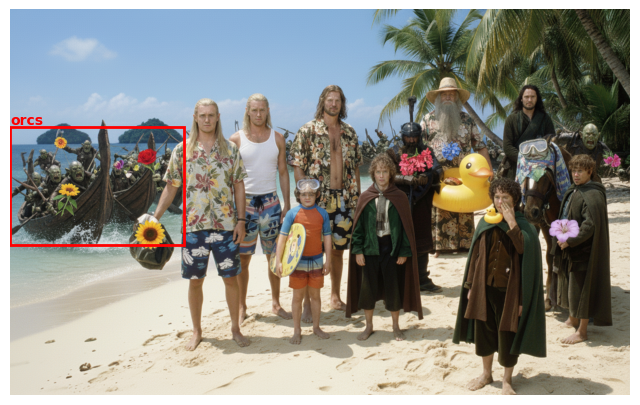

In [8]:
image = Image.open('bros6.png')

prompt = "Detect all orcs and return bounding boxes as JSON with fields bbox_2d [x1,y1,x2,y2] and label."

response, h, w = zero_shot_inference(model, processor, image, prompt)
print(response)
plot_bounding_boxes(image, response, h, w)
